# Loading models

##### Additional function to display and save results

In [73]:
import importlib.util
import os
import sys

import basicsr
import cv2
import numpy as np
import realesrgan
from matplotlib import pyplot as plt


def display_and_save_result(use_function, input_image_path, output_image_path, caption):
    lr_image = cv2.imread(input_image_path).astype(np.float32) / 255.0

    sr_image = use_function(lr_image)

    lr_image = np.clip(lr_image, 0, 1)
    sr_image = np.clip(sr_image, 0, 1)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Low-Resolution Image")
    plt.imshow(cv2.cvtColor(lr_image, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Super-Resolved Image")
    plt.imshow(cv2.cvtColor(sr_image, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.show()

    os.makedirs(os.path.dirname(output_image_path), exist_ok=True)

    sr_image_to_save = (sr_image * 255).astype(np.uint8)
    cv2.imwrite(output_image_path, sr_image_to_save)
    print(f"Upscaled image saved to: {output_image_path}")


def import_module_from_path(module_name, file_path):
    spec = importlib.util.spec_from_file_location(module_name, file_path)
    module = importlib.util.module_from_spec(spec)
    sys.modules[module_name] = module
    spec.loader.exec_module(module)
    return module

## FSRCNN

In [64]:
import torch

In [65]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

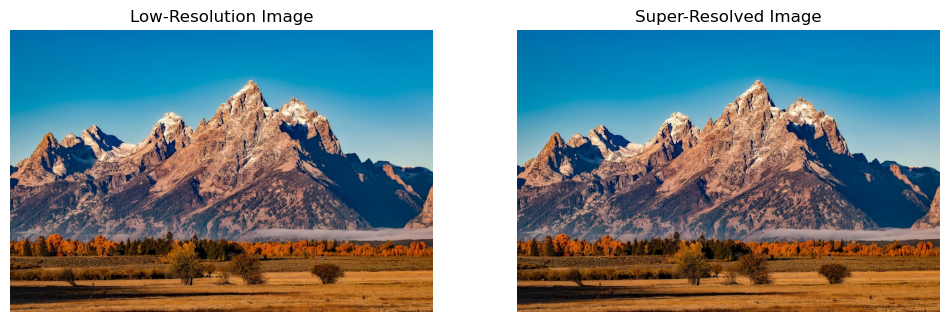

Upscaled image saved to: assets/210243-FSRCNN.png


In [66]:
from models.FSRCNN.repository.model import FSRCNN

fsrcnn_model = FSRCNN(upscale_factor=3)
fsrcnn_checkpoint = torch.load('./models/FSRCNN/weights/fsrcnn_x3-T91-55ffd1d6.pth.tar', map_location=device)
fsrcnn_model.load_state_dict(fsrcnn_checkpoint['state_dict'])
fsrcnn_model = fsrcnn_model.to(device)
fsrcnn_model.eval()


def use_fsrcnn_model(lr_image, model, device):
    lr_ycbcr = cv2.cvtColor(lr_image, cv2.COLOR_BGR2YCrCb)
    lr_y, lr_cb, lr_cr = cv2.split(lr_ycbcr)

    lr_y_tensor = torch.tensor(lr_y).unsqueeze(0).unsqueeze(0).to(device)

    with torch.no_grad():
        sr_y_tensor = model(lr_y_tensor)

    sr_y = sr_y_tensor.squeeze(0).squeeze(0).cpu().numpy()
    sr_y = np.clip(sr_y, 0, 1)

    sr_cb = cv2.resize(lr_cb, (sr_y.shape[1], sr_y.shape[0]), interpolation=cv2.INTER_CUBIC)
    sr_cr = cv2.resize(lr_cr, (sr_y.shape[1], sr_y.shape[0]), interpolation=cv2.INTER_CUBIC)

    sr_ycbcr = cv2.merge([sr_y, sr_cb, sr_cr])
    sr_image = cv2.cvtColor(sr_ycbcr, cv2.COLOR_YCrCb2BGR)

    return sr_image


def fsrcnn_use_function(lr_image):
    return use_fsrcnn_model(lr_image, fsrcnn_model, device)


input_image_path = "assets/210243.png"
output_image_path = "assets/210243-FSRCNN.png"
display_and_save_result(fsrcnn_use_function, input_image_path, output_image_path, caption="FSRCNN Super-Resolution")

## Real-ESRGAN

In [84]:
import torchvision

torchvision.transforms.functional_tensor = torchvision.transforms.functional

In [85]:
from models.RealESRGAN.repository.realesrgan.models.realesrgan_model import RealESRGANModel

realesrgan_model = RealESRGANModel(opt={
    "scale": 4,
    "queue_size": 180,
    "resize_prob": [0.2, 0.7, 0.1],
    "resize_range": [0.5, 1.0],
    "noise_range": [1, 30],
    "poisson_scale_range": [0.05, 3],
    "jpeg_range": [30, 95],
    "gt_size": 128,
    "gray_noise_prob": 0.4,
    "gaussian_noise_prob": 0.5,
    "second_blur_prob": 0.8,
    "resize_prob2": [0.3, 0.4, 0.3],
    "resize_range2": [0.3, 1.2],
    "noise_range2": [1, 25],
    "poisson_scale_range2": [0.05, 2.5],
    "jpeg_range2": [20, 90],
    "l1_gt_usm": True,
    "percep_gt_usm": True,
    "gan_gt_usm": True,
    "high_order_degradation": True
})
realesrgan_checkpoint = torch.load("./models/RealESRGAN/weights/RealESRGAN_x4plus.pth", map_location="cuda")
realesrgan_model.load_state_dict(realesrgan_checkpoint["state_dict"])
realesrgan_model = realesrgan_model.cuda()
realesrgan_model.eval()

ModuleNotFoundError: No module named 'torchvision.transforms.functional_tensor'